In [1]:
from  pyspark.sql.functions import input_file_name
from pyspark.sql.types import *
from pyspark.sql.functions import split, col, lower
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf, concat 
from pyspark.ml import Pipeline
from  pyspark.sql.functions import input_file_name
from pyspark.sql.types import *
from pyspark.sql.functions import split, lower
from pyspark.ml.feature import NGram, FeatureHasher, CountVectorizer, RegexTokenizer
import re
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import nltk
from textblob import TextBlob
from urllib.request import urlopen
import urllib
import requests
import io
import multiprocessing, os
from multiprocessing.pool import ThreadPool
import pyarrow
import numpy as np
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from pyspark.sql.types import StringType, FloatType
from pyspark.sql.functions import udf

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kwjennin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
%%bash
scancel -u kwjennin -n sparkcluster
squeue -u kwjennin

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
              8861     cpu24 jupyterh kwjennin  R    2:23:47      1 b09


In [7]:
import os, atexit, sys, findspark, sparkhpc, pyspark
from pyspark.context import SparkContext
from pyspark.sql import SQLContext

findspark.init()

os.environ['SBATCH_PARTITION']='cpu24'

sj = sparkhpc.sparkjob.sparkjob(
    ncores = 10,                          # total number or cores
    cores_per_executor = 5,              # parallelism of a single executor
    memory_per_core = 10240,  # memory per core in MB
    walltime = "3:0"                      # hh:mm format
)

sj.wait_to_start()
sc = sj.start_spark()
scq = SQLContext(sc)

def exitHandler(sj,sc):
    try:
        print('Trapped Exit cleaning up Spark Context')
        sc.stop()
    except:
        pass
    try:
        print('Trapped Exit cleaning up Spark Job')
        sj.stop()
    except:
        pass
atexit.register(exitHandler,sj,sc);
sc

INFO:sparkhpc.sparkjob:Submitted batch job 8892

INFO:sparkhpc.sparkjob:Submitted cluster 0


<SparkContext master=spark://b07:7077 appName=pyspark-shell>

# Text analysis of Amazon product reviews

### DS 608 Project
##### By Keith Jenning, Ryan Leeson

## Introduction

#### Sentiment analysis is a common problem in the field of machine learning. In this project, we attempt to build a classifier to predict the Star rating of an Amazon review using the text of the review for individual products. The advantage of using the Amazon review dataset is that it does not only include text-based data, it also includes an evaluation system in the form of a five star rating, where one and two stars show dislike or displeasure, four and five show people like and enjoy something, and three stars is a neutral position. With review texts and the associated star rating a model can be trained to evaluate a post and classifying it with a star rating to indicate whether the post indicates like or dislike regard the subject of the post. To do this, we make use of the TextBlob package to determine how positive or negative a review is, as well as determine the number of positive or negative words in the review, and relating it the Star rating of the product.


#### Note: Due to issues running the file for over 18 hours on the full dataset, we were unable to have our model complete. Thus, we have chosen a single file in order to demonstrate its performance on a sample of the data.

## Dataset

#### The datset was was compiled by Jianomo Ni, a Ph.D. student from the University of California San Diego. The dataset is hosted on a github repository controlled by Mr. Ni. 

#### The dataset is stored as 29 seperate Json files. Each file consists of the reviews for each product category. The files vary in size from ~100 MB to the largest file, which are book reviews which is ~7 GB. Overall, all the files combined contain approximately 14 GB of data.

#### The data include product reviews taken from 1996 up to the year 2018. The features of the dataset include response variable, 'overall,' which is overall rating of the product on a five point scale. Other features include the 'asin' which is a product identifier, 'image' which is a link to an image of the product, if available. For the reviews, there is the 'reviewText' which is the full review text written by the review author. Other features included are the time the review was made, as a date and as a UNIX timestamp, 'revieTime' and 'unixReviewTime.' There are also the reviewer's name, 'reviewerName,' and ID; 'reviewerID,' the 'summary,' a short text briefly stating the authors thoughts, 'verified' varifying the author of the product made the purchase, and 'vote' summarising whether the review received up or down votes.

#### The dataset was pre-cleaned by Mr. Ni. Mr. Ni has versions of the files available through his github repo. The master file, containing all reviews collected by Mr. Ni, includes over 233 million reviews and is approximately 34 GB in size. The dataset used is referred to as a 5-core dataset. The title is defined to indicate that only products with a minimum of five reivews or reviews who have left a minimum of five reviews were included.

## Methods

### File collection
#### The code used to download the files from Mr. Ni's gihub page is provided in a different file titled 'batch_program_for_download.ipynb.'


#### The download was done through a programmed written as a SLURM job run on the University of Calgary's TALC cluster system. Using one node and 16 cores, the job took 50.3 minutes (3020.565 s) to download all the files.

### Converting files to parquet

#### Due to issues running the full 14GB file in Jupyter and the Google cluster, we selected a single file to run the model on.

In [25]:
# df_reviews = scq.read.json('/home/kwjennin/Data608/Project/Files/*.json.gz')
df_reviews = scq.read.json('/home/kwjennin/Data608/Project/Files/appliances.json.gz')
#   There is a 'Files' folder where all the files were stored.



In [26]:
(df_reviews
 ##########
 #   Adding a category feature.
 .withColumn('filename', input_file_name())
 .withColumn('file_cn', split(col('filename'), 'Files/').getItem(1))
 #   This line is dependent on how files were organised
 .withColumn('category', lower(split(col('file_cn'), '_5.json').getItem(0)))
 ##########
 .select(['asin', 'overall', 'reviewText', 'reviewTime', 'reviewerID', 'summary', 'unixReviewTime', 'verified', 'category'])
 .write.parquet('/home/kwjennin/Data608/Project/Files/amazon_reviews.parquet', mode = 'overwrite', partitionBy = 'category')
)



#### The original downloaded files were stored in json format with Gzip compression. Using pyspark the data was read into a spark dataframe and exported as new files in parquet format using snappy compression.

#### Using the titles of the files, a new category column was added to the data. During the creation of the parquet files, the category was used to partion the parquets, resulting in files like those originally downloaded.

#### A custom schema was not implemented for reading the json files. Two features, 'photo' and 'style,' contained nested structures. These nested structures caused issues when reading the json files. Also, the nested comp

#### During this process, two columns were removed from the dataset, 'photo' and 'style.' 

#### Two columns in the dataset, 'photo' and 'style', were nested. These nested structures were different for each file, making it difficult to create a custom schema for the files. Testing several files showed that read.json () was able to infer the schema of the dataset without issue. As a result, all the files could be imported and merged with one read.json () command.

In [27]:
#   importing dataset, only columns 'overall' and 'reviewText

reviews_labels = scq.read.parquet('/home/kwjennin/Data608/Project/Files/amazon_reviews.parquet').select ('overall', 'reviewText')

reviews_labels.show(3)



+-------+--------------------+
|overall|          reviewText|
+-------+--------------------+
|    5.0|I like this as a ...|
|    5.0|           good item|
|    5.0|Fit my new LG dry...|
+-------+--------------------+
only showing top 3 rows



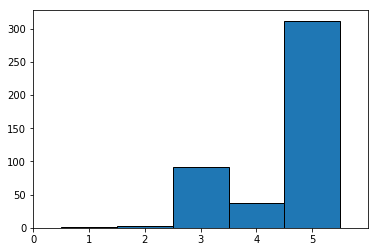

In [28]:
import matplotlib.pyplot as plt

sample_df = reviews_labels.sample(False, 0.2)

pdf = sample_df.toPandas()

data = pdf['overall']
data = data.astype('int64')
counts = np.bincount(data)

fig, ax = plt.subplots()
ax.bar(range(6), counts, width=1, align='center', edgecolor = 'black')
ax.set(xticks=range(6), xlim=[0, 6])

plt.show()


## Classifier

#### We load the necessary elements to perform sentiment analysis on the review text column of the dataframe. Following that we create columns using user-defined functions. The main output columns from the functions that will be used for the classifier are the sentence polarity, positive word count, and negative word count.


In [29]:
#create new columns
def full(string):
    stemmer = PorterStemmer()

    stop = stopwords.words('english')

    tokenizer = RegexpTokenizer(r'\w+')
    
    ls = []
    stop = stopwords.words('english')
    if string is not None:
        for word in string.split():
            if word not in stop:
                ls.append(word)
    text = ' '.join(ls)
    sentencePolarity = TextBlob(string).sentiment.polarity
    
    tokenized = tokenizer.tokenize(text)
    
    polarityPos = []
    for word in tokenized:
        if TextBlob(word).sentiment.polarity > 0:
            polarityPos.append(word)
            
    polarityNeg = []
    for word in tokenized:
        if TextBlob(word).sentiment.polarity < 0:
            polarityNeg.append(word)
            
    posWordCount = sum([polarityPos.count(w) for w in polarityPos])
    negWordCount = sum([polarityNeg.count(w) for w in polarityNeg])
    
    return sentencePolarity, posWordCount, negWordCount

schema = StructType([
    StructField("sentencePolarity", DoubleType(), False),
    StructField("posWordCount", IntegerType(), False),
    StructField("negWordCount", IntegerType(), False)])

full_udf = udf(full, schema)

reviews_labels = reviews_labels.withColumn("Output", full_udf(reviews_labels.reviewText))

reviews_labels = reviews_labels.select("Overall", "Output.*")

reviews_labels.show(3)

+-------+------------------+------------+------------+
|Overall|  sentencePolarity|posWordCount|negWordCount|
+-------+------------------+------------+------------+
|    5.0|               0.4|           1|           0|
|    5.0|               0.7|           1|           0|
|    5.0|0.5121212121212121|           3|           0|
+-------+------------------+------------+------------+
only showing top 3 rows



#### We select the columns that are required for the classifier, convert the columns to the necessary type, and then give a count of each class in the dataframe. Following that, we trained a random forest classifier to predict the class label. The accuracy was approximately 70% which corresponds to the percent of 5 Star reviews in the dataframe. Further investigation showed that the majority of the labels predicted were 5 Star. Due to this labelling issue, we will attempt another classification method: the one vs. rest classifier.

In [30]:
reviews_labels_select = reviews_labels.select('overall', 'sentencePolarity', 'posWordCount', 'negWordCount')

for c in reviews_labels_select.columns:
    reviews_labels_select = reviews_labels_select.withColumn(c, reviews_labels_select[c].cast('double'))

import pyspark.sql.functions as f

reviews_labels_select.groupBy('overall').count().select('overall', f.col('count').alias('n')).show()



+-------+----+
|overall|   n|
+-------+----+
|    1.0|   9|
|    4.0| 222|
|    3.0| 421|
|    2.0|  13|
|    5.0|1612|
+-------+----+



#### Our attempt to implement the one vs. rest classifier ran into the same issue as the random forest classifier: the majority of predictions were 5 Star. Unfortunately, there is no ability in PySpark to weight columns due to an imbalanced dataset for the random forest or the one vs. rest algorithms. It is, however, implemented in the logistic regression. Thus, our next attempted algorithm will be the multinomial logistic regression.

#### As can be seen in the output, the weighting has reduced our accuracy. Although this is a decrease in our performance metric, we can now be confident that the classifier is performing a more intelligent prediction instead of an almost constant prediction.

In [31]:
#Begin Multinomial Logistic Regression with Weights
df = reviews_labels_select.withColumnRenamed('overall', 'label')

df = df.select('label', 'sentencePolarity', 'posWordCount', 'negWordCount')

#create column weights
label_freq = df.select("label").groupBy("label").count().collect()
unique_label = [x["label"] for x in label_freq]
total_label = sum([x["count"] for x in label_freq])
unique_label_count = len(label_freq)
bin_count = [x["count"] for x in label_freq]

label_weights = {i: ii for i, ii in zip(unique_label, total_label / (unique_label_count * np.array(bin_count)))}
print(label_weights)

from itertools import chain

mapping_expr = f.create_map([f.lit(x) for x in chain(*label_weights.items())])

df = df.withColumn("weight", mapping_expr.getItem(f.col("label")))



{1.0: 50.6, 4.0: 2.0513513513513515, 3.0: 1.081710213776722, 2.0: 35.03076923076923, 5.0: 0.2825062034739454}


In [32]:
#assemble feature vector
from pyspark.ml.feature import VectorAssembler
features = ['sentencePolarity', 'posWordCount', 'negWordCount']
assembled = VectorAssembler(inputCols=features, outputCol="features")

df = assembled.transform(df.select(['label', 'sentencePolarity', 'posWordCount', 'negWordCount', 'weight'])).cache()

df = df.select('label', 'features', 'weight')



In [33]:
#split data and initialize model
from pyspark.ml.classification import LogisticRegression

(training, test) = df.randomSplit([0.8, 0.2])

lr = LogisticRegression(weightCol = 'weight')



In [ ]:
#fit the model on training set
lrModel = lr.fit(training)



In [15]:
#get predictions on test set
predictions = lrModel.transform(test)

predictions.select("prediction", "label", "features").show(3, truncate = False)



+----------+-----+--------------------------------+
|prediction|label|features                        |
+----------+-----+--------------------------------+
|1.0       |1.0  |[0.04393939393939394,2.0,1.0]   |
|5.0       |1.0  |[0.07562858017403473,18.0,8.0]  |
|3.0       |2.0  |[-0.019301470588235305,19.0,3.0]|
+----------+-----+--------------------------------+
only showing top 3 rows



In [16]:
#retrieve evaluation metrics
from pyspark.mllib.evaluation import MulticlassMetrics

results = predictions.select('prediction', 'label')
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)
f1Score = metrics.fMeasure()

print("F Score = %g" % (f1Score))



F Score = 0.521834


#### We next compare the weighted multinomial logistic regression with one that samples an equal number of classes without the weight column. We can see the accuracy decreases. Additionally, this data sample is no longer 'big data'.

In [22]:
#Begin Multinomial Logistic Regression with Equal Samples
df = reviews_labels_select.withColumnRenamed('overall', 'label')

df = df.select('label', 'sentencePolarity', 'posWordCount', 'negWordCount')



In [23]:
#assemble feature vector
from pyspark.ml.feature import VectorAssembler
features = ['sentencePolarity', 'posWordCount', 'negWordCount']
assembled = VectorAssembler(inputCols=features, outputCol="features")

df = assembled.transform(df.select(['label', 'sentencePolarity', 'posWordCount', 'negWordCount'])).cache()

df = df.select('label', 'features')



In [24]:
#sample each class in equal sizes, split data, and initialize model
sampled = df.sampleBy('label', fractions = {1:0.4793, 2:1, 3:0.4499, 4:0.2384, 5:0.1204})

(training, test) = sampled.randomSplit([0.8, 0.2])

from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression()



In [25]:
#fit model on training data
lrModel = lr.fit(training)



In [26]:
#compare model with test set
predictions = lrModel.transform(test)

predictions.select("prediction", "label", "features").show(3, truncate = False)



+----------+-----+---------+
|prediction|label|features |
+----------+-----+---------+
|1.0       |1.0  |(3,[],[])|
|1.0       |1.0  |(3,[],[])|
|1.0       |1.0  |(3,[],[])|
+----------+-----+---------+
only showing top 3 rows



In [27]:
#get performance metrics
from pyspark.mllib.evaluation import MulticlassMetrics

results = predictions.select('prediction', 'label')
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)
f1Score = metrics.fMeasure()

print("F Score = %g" % (f1Score))



Accuracy = 0.317143
F Score = 0.317143


#### Next we tune our hyperparameters using cross validation for multinomial logistic regression. The accuracy only marginally improves.

In [17]:
#Cross Validation Logistic Regression
df = reviews_labels_select.withColumnRenamed('overall', 'label')

df = df.select('label', 'sentencePolarity', 'posWordCount', 'negWordCount')



In [18]:
#get class weights
label_freq = df.select("label").groupBy("label").count().collect()
unique_label = [x["label"] for x in label_freq]
total_label = sum([x["count"] for x in label_freq])
unique_label_count = len(label_freq)
bin_count = [x["count"] for x in label_freq]

label_weights = {i: ii for i, ii in zip(unique_label, total_label / (unique_label_count * np.array(bin_count)))}
print(label_weights)

import pyspark.sql.functions as f
from itertools import chain

mapping_expr = f.create_map([f.lit(x) for x in chain(*label_weights.items())])

df = df.withColumn("weight", mapping_expr.getItem(f.col("label")))



{1.0: 50.6, 4.0: 2.0513513513513515, 3.0: 1.081710213776722, 2.0: 35.03076923076923, 5.0: 0.2825062034739454}


In [19]:
#assemble feature vector
from pyspark.ml.feature import VectorAssembler
features = ['sentencePolarity', 'posWordCount', 'negWordCount']
assembled = VectorAssembler(inputCols=features, outputCol="features")

df = assembled.transform(df.select(['label', 'sentencePolarity', 'posWordCount', 'negWordCount', 'weight'])).cache()

df = df.select('label', 'features', 'weight')



In [20]:
#split data and initialize model
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

(training, test) = df.randomSplit([0.8, 0.2])

lr = LogisticRegression(weightCol = 'weight')



In [22]:
#cross validate
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

grid = ParamGridBuilder().addGrid(lr.maxIter, [10, 20, 25]) \
                                .addGrid(lr.regParam, [0, 0.01, 0.05, 0.1, 0.5, 1]) \
                                .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.5, 0.8, 1]) \
                                .build()

lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, \
                        evaluator=evaluator, numFolds=3)



In [23]:
#fit model on training data
lrModel = lr_cv.fit(training)



In [24]:
#choose best model and compare model with test set
bestModel = lrModel.bestModel

predictions = bestModel.transform(test)

predictions.select("prediction", "label", "features").show(3, truncate = False)



+----------+-----+--------------------------------+
|prediction|label|features                        |
+----------+-----+--------------------------------+
|1.0       |2.0  |[-0.019301470588235305,19.0,3.0]|
|1.0       |2.0  |[0.014772727272727274,2.0,1.0]  |
|2.0       |2.0  |[0.4,1.0,0.0]                   |
+----------+-----+--------------------------------+
only showing top 3 rows



In [25]:
#get performance metrics
from pyspark.mllib.evaluation import MulticlassMetrics

results = predictions.select('prediction', 'label')
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)
f1Score = metrics.fMeasure()

print("F Score = %g" % (f1Score))



F Score = 0.477895


## Conclusion
#### This project was intended to show a method of classifying Amazon reviews into their appropriate 5 Star ratings. The data posed many problems both with the challenges of the size of the data and with fitting an accurate model. Although the final model's accuracy is better than a random algorithm which would yield 20% accuracy, we note that it underperforms a constant choice algorithm which yields 70% accuracy. This leads to the question of whether it is better to predict based off of the most common class in order to achieve a higher accuracy, or to use an algorithm which attempts to use features to predict a class but ultimately ahieves a lower accuracy. Perhaps better feature engineering would have yielded better results or perhaps it is the case that ratings are not always predictable based off of review text.

## Future work

In future more can be done to attempt to improve the predictions of the model. This includes 
* Determine the issue with the large datset
* Selection another model, possibly a random forest classifier
* Over-estimating the smaller sized classes
* Using One-vs-rest classification
* Examine the influence of category


## References
#### 1. Amazon Review Data (2018): https://nijianmo.github.io/amazon/index.html
#### 2. https://danvatterott.com/blog/2019/11/18/balancing-model-weights-in-pyspark/
#### 3. https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1
#### 4. https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
#### 5.  https://medium.com/analytics-vidhya/confusion-matrix-accuracy-precision-recall-f1-score-ade299cf63cd


In [5]:
%%bash
squeue -u kwjennin

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
              8231     cpu24 sparkclu kwjennin  R       1:29      2 b[05-06]
              8195     cpu24 jupyterh kwjennin  R    2:44:31      1 b12


## Note on analysis of full dataset.

#### Data exploration of full dataset are provided in the notebook 'data_exploration_full_dataset.ipynb'.

#### The original procedure we developed and started was done using the 'musical_instruments.json.gz' dataset. Unfortunately, we were unable to fit a model using the entire dataset of all 29 datasets merged together. We first attempted using the TALC cluster, however, the result was the model fitting never ending and then the kernel would be disrupted or access to TALC would timeout. This would disrupt the model fitting, so it could never be completed. 

#### We also tried creating a cluster on Google cloud services. The configuration of the cluster is outlined below. Because of the size of the files, it was not possible to upload all the data to Google storage. However, we were able to load all but one of the files, Books_5.json.gz, which is the largest file at approximately 7 GB. Like TALC, the Google cluster was able the perform all the data wrangling. But, even with the smaller amount of data, the cluster still could not fit the model. Unline TALC, the Google cluster would return an error message concerning a failed container from one of the nodes. Some investigation of the error appears to indicate that it concerns a memory or disk issue. So, it is possible that hte dataset is too large for the clusters, or there are too many tasks involved in fitting the model with this dataset that the cluster is being overwelmed. Another attempt was made on Google cloud services with a two node cluster with eight cores and 100 CB of disk each. This cluster still could not fit the model with the dataset.

#### Due to the inability of the TALC and Google clusters to handle the entire dataset, we instead tried to fit the model to one of the individual dataset, the 'software.json.gz' dataset.

#### The model fitting was run as a SLURM job on the cpu24 and cpu32-bigmem systems. The random forest classifier was able to be fit on a spark cluster on a cpu24 system over SLURM. The job ran for around 7 hours before it crashed. The accuracy of the model was found to be 65 %, however, the program failed and was cut off due to a lack of memory. This appears to confirm the issue encountered with the Google cluster.

#### The notebooks for the analysis of the full dataset are 'pipeline_with_balanced_dataset.ipynb' and 'pipeline_with_unbalanced_dataset.ipynb'. The code in 'pipeline_with_balanced_dataset.ipynb' was run on cpu24 and cpu32-bigmem.

#### All the jobs run on cpu32-bigmem did not complete. It appears that more system resources are necessary to perform this analysis.

### Google cloud cluster configuration

gcloud beta dataproc clusters create cluster-1d88 --enable-component-gateway --bucket data608_bucket --region us-central1 --subnet default --zone us-central1-a --master-machine-type n1-standard-4 --master-boot-disk-size 32 --num-workers 5 --worker-machine-type n1-standard-2 --worker-boot-disk-size 32 --image-version 1.4-ubuntu18 --optional-components ANACONDA,JUPYTER --scopes 'https://www.googleapis.com/auth/cloud-platform' --project myds608test